In [1]:
import pandas as pd

In [2]:
drug = pd.read_csv("../data/eICU/infusiondrug.csv")
diagnosis = pd.read_csv("../data/eICU/diagnosis.csv")
patients_weight = pd.read_csv("../data/eICU/patient.csv")[["patientunitstayid", "admissionweight"]]
patient = pd.read_csv("../data/eICU/patient.csv")
drug = drug.merge(patients_weight, on="patientunitstayid")

c:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# add hospitalID and unitType and wardID to the drug table corelated to patientunitstayid
drug["hospitalid"] = drug["patientunitstayid"].map(patient.set_index("patientunitstayid")["hospitalid"])
drug["unittype"] = drug["patientunitstayid"].map(patient.set_index("patientunitstayid")["unittype"])
drug["wardid"] = drug["patientunitstayid"].map(patient.set_index("patientunitstayid")["wardid"])

In [4]:
# filter drug from NA in drugname, patientunitstayid, hospitalid, unittype, wardid
drug = drug[~drug['drugname'].isna()]
drug = drug[~drug['patientunitstayid'].isna()]
drug = drug[~drug['hospitalid'].isna()]
drug = drug[~drug['unittype'].isna()]
drug = drug[~drug['wardid'].isna()]

#filter drugs with other drug names
other_drugs = drug[drug['drugname'].str.startswith(("Epinephrine", "Dopamine", "Vesopressin"))]

#filter drug to include only drugnames that start with "Norepinephrine"
drug = drug[drug['drugname'].str.startswith("Norepinephrine")]

#remove patients who recieved other vasopressors
drug = drug[~drug['patientunitstayid'].isin(other_drugs['patientunitstayid'])]

In [5]:
# sort drug by patientunitstayid and drugstartoffset
drug = drug.sort_values(by=["patientunitstayid", "infusionoffset"])
drug

,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight,admissionweight,hospitalid,unittype,wardid
4,1969910,242082,55,Norepinephrine (mcg/min),2.13,8.0,4.0,250.0,NaN,90.7,108,Med-Surg ICU,136
2,1968206,242082,125,Norepinephrine (mcg/min),7,26.3,4.0,250.0,NaN,90.7,108,Med-Surg ICU,136
10,1985898,242082,230,Norepinephrine (mcg/min),9.07,34.0,4.0,250.0,NaN,90.7,108,Med-Surg ICU,136
12,1972141,242082,275,Norepinephrine (mcg/min),10,37.5,4.0,250.0,NaN,90.7,108,Med-Surg ICU,136
1,1998443,242082,425,Norepinephrine (mcg/min),10.93,41.0,4.0,250.0,NaN,90.7,108,Med-Surg ICU,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803535,75122092,3353251,3823,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,15,NaN,NaN,NaN,NaN,102.0,458,Cardiac ICU,1104
4803681,75308975,3353251,3968,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,16,NaN,NaN,NaN,NaN,102.0,458,Cardiac ICU,1104
4803654,75246300,3353251,4043,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,12,NaN,NaN,NaN,NaN,102.0,458,Cardiac ICU,1104
4803592,75148203,3353251,4358,Norepinephrine MAX 32 mg Dextrose 5% 250 ml (m...,10,NaN,NaN,NaN,NaN,102.0,458,Cardiac ICU,1104


In [6]:
drug.groupby(["hospitalid", "unittype"])["patientunitstayid"].nunique().sort_values()

hospitalid  unittype    
265         MICU              1
148         Med-Surg ICU      1
151         Med-Surg ICU      1
156         Med-Surg ICU      1
393         Med-Surg ICU      1
                           ... 
345         Med-Surg ICU    326
167         Med-Surg ICU    346
188         MICU            357
199         Med-Surg ICU    383
300         Med-Surg ICU    406
Name: patientunitstayid, Length: 193, dtype: int64

In [7]:
bp = pd.read_csv("../preprocess/filtered_bp_eicu.csv")
bp = bp.sort_values(by=["stay_id", "cur_bp_time"])
bp = bp[bp["stay_id"].isin(drug["patientunitstayid"])]
bp["next_bp_time"] = bp.groupby("stay_id")["cur_bp_time"].shift(-1)
bp["interval"] = bp["next_bp_time"] - bp["cur_bp_time"]
drug["drugrate"] = pd.to_numeric(drug["drugrate"], errors='coerce')
bp["age"] = pd.to_numeric(bp["stay_id"].map(patient.set_index("patientunitstayid")["age"]), errors='coerce')
bp["hospitalid"] = bp["stay_id"].map(patient.set_index("patientunitstayid")["hospitalid"])
bp["unittype"] = bp["stay_id"].map(patient.set_index("patientunitstayid")["unittype"])
bp["wardid"] = bp["stay_id"].map(patient.set_index("patientunitstayid")["wardid"])
# create a new column for the number of patients per hospital
# bp["pat_per_hos"] = bp["hospitalid"].map(bp.groupby(["hospitalid"]).agg({"stay_id": ["nunique"]}).sort_values(by=("stay_id", "nunique")))


In [8]:
# find the number of patients per hospital
bp.groupby(["hospitalid"]).agg({"stay_id": ["nunique"]}).sort_values(by=("stay_id", "nunique"))


,stay_id
,nunique
hospitalid,
266,1
279,1
312,1
336,1
345,1
...,...
148,130
154,131


In [10]:
bp["pat_per_hos"]

KeyError: 'pat_per_hos'

In [11]:
# give me a table of hospitals, wardid and number of patients per hospital
bp_hospital = bp.groupby(['hospitalid']).agg({'stay_id': ['nunique']})

In [12]:
bp["stay_id"].unique()

array([ 243334,  243643,  244256, ..., 3352721, 3353144, 3353251],
      dtype=int64)

In [13]:
print(f'Number of patients in the dataset: {bp_big["stay_id"].nunique()}')
print(f'Number of hospitals in the dataset: {bp_big["hospitalid"].nunique()}')
print(f'Number of patients per hospital in the dataset: {bp_big["pat_per_hos"].unique()}')

NameError: name 'bp_big' is not defined

In [14]:
# bp_big will consist of patients from hospitalid with more then 400 differnt patientsunitstayid
bp_big = bp[bp["hospitalid"].isin(drug.groupby("hospitalid")["patientunitstayid"].nunique().sort_values()[drug.groupby("hospitalid")["patientunitstayid"].nunique().sort_values() > 400].index)]
bp_big

,Unnamed: 0,stay_id,cur_bp_time,cur_bp,next_bp_time,interval,age,hospitalid,unittype,wardid
3366621,222244,534898,965,54.0,970.0,5.0,71.0,176,CSICU,391
3366566,222100,534898,970,60.0,975.0,5.0,71.0,176,CSICU,391
3366524,222016,534898,975,55.0,980.0,5.0,71.0,176,CSICU,391
3366490,221944,534898,980,55.0,985.0,5.0,71.0,176,CSICU,391
3366466,221884,534898,985,59.0,990.0,5.0,71.0,176,CSICU,391
...,...,...,...,...,...,...,...,...,...,...
2656012,667916,3130257,110,73.0,115.0,5.0,74.0,420,CCU-CTICU,1035
2656027,667932,3130257,115,64.0,120.0,5.0,74.0,420,CCU-CTICU,1035
2656014,667919,3130257,120,15.0,125.0,5.0,74.0,420,CCU-CTICU,1035
2656016,667921,3130257,125,27.0,130.0,5.0,74.0,420,CCU-CTICU,1035


In [15]:
bp_big["stay_id"].nunique()

912

In [23]:
# create a plot of bp over time for each patient using plotly subplot and add to each patient plot the norepinephrine infusion from drug table as scatter plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
for i in range(100):
    # assign random patient to pat
    pat = bp_big["stay_id"].value_counts()[bp_big["stay_id"].value_counts() > 0].sample(5).index[0]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=bp_big[bp_big["stay_id"] == pat]["cur_bp_time"], y=bp_big[bp_big["stay_id"] == pat]["cur_bp"], name="MAP"))
    # scatter plot of norepinephrine infusion, not line plot
    # fig.add_trace(go.Scatter(x=drug[drug["patientunitstayid"] == pat]["infusionoffset"], y=drug[drug["patientunitstayid"] == pat]["drugrate"], name="drug", mode="markers", marker=dict(color="red")), row=i+1, col=1)
    x = drug[drug["patientunitstayid"] == pat]["infusionoffset"]
    z = drug[drug["patientunitstayid"] == pat]["drugrate"]
    # make z values between 0 and 10
    z2 = (z - z.min()) / (z.max() - z.min()) * 10
    # set y as a liitle under the min of bp and higher drugrate be higher
    y = bp_big[bp_big["stay_id"] == pat]["cur_bp"].min() - 10 + z2
    fig.add_trace(go.Scatter(x=x, y=y * np.ones(x.size), name="NOR", mode="markers", marker=dict(color=z,colorscale='Viridis',
        colorbar=dict(title='NOR')
    ),
    )) # TODO added drug amount as color
    fig.update_layout(title_text="bp over time for 5 patients")
    fig.write_image(f"bp{i}.png")
    # create a histogram of bp values for the patient
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=bp_big[bp_big["stay_id"] == pat]["cur_bp"], name="bp"))
    fig.update_layout(title_text="bp over time for patient")
    fig.write_image(f"bp_hist{i}.png")



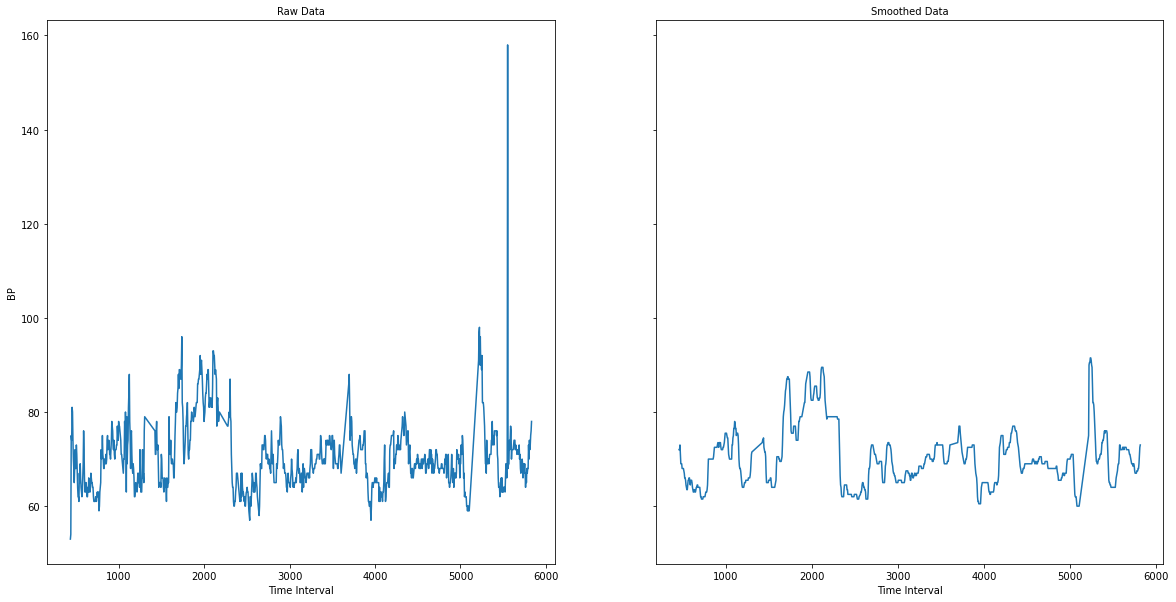

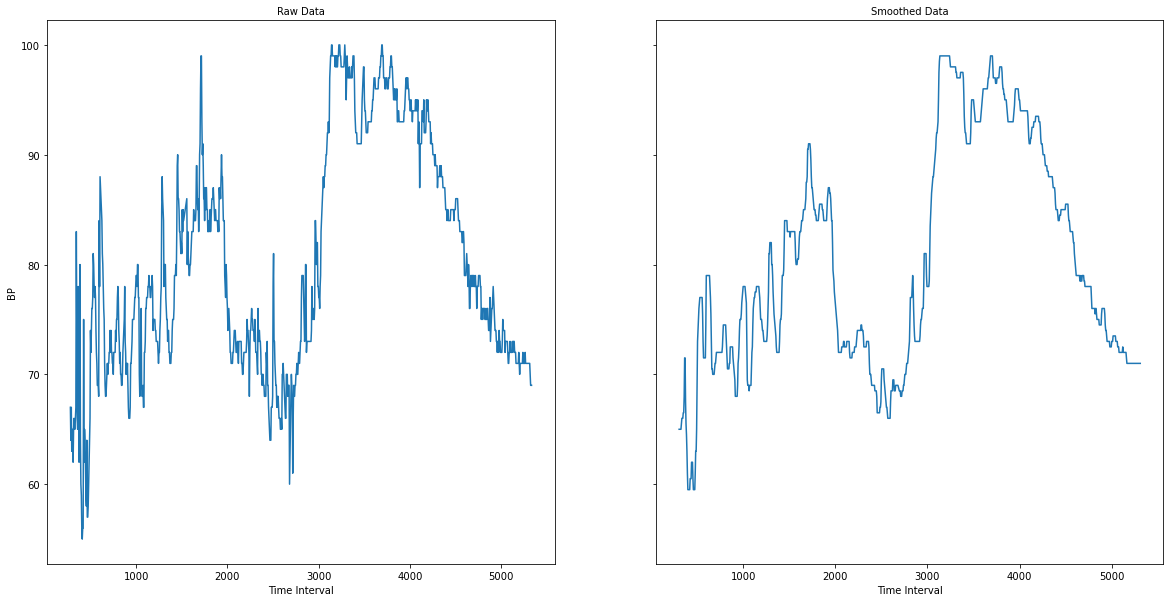

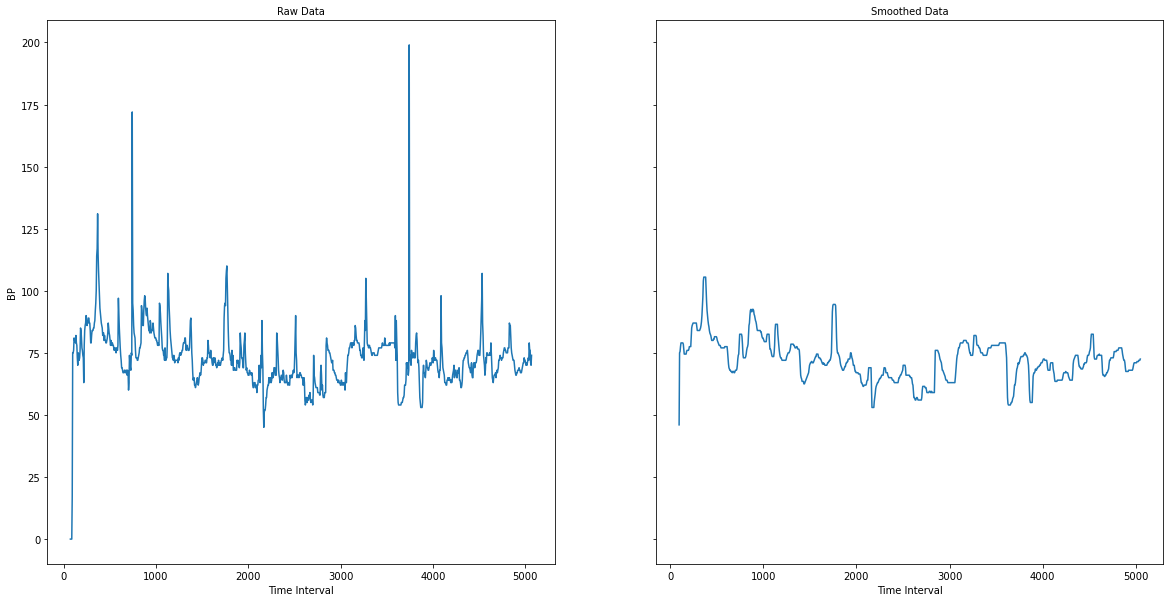

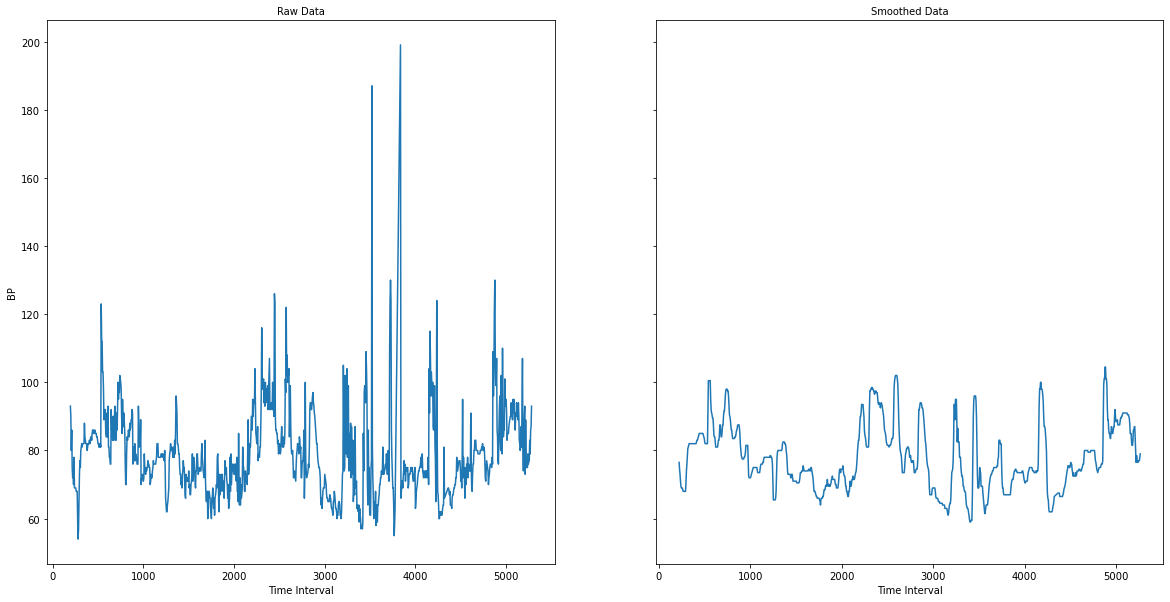

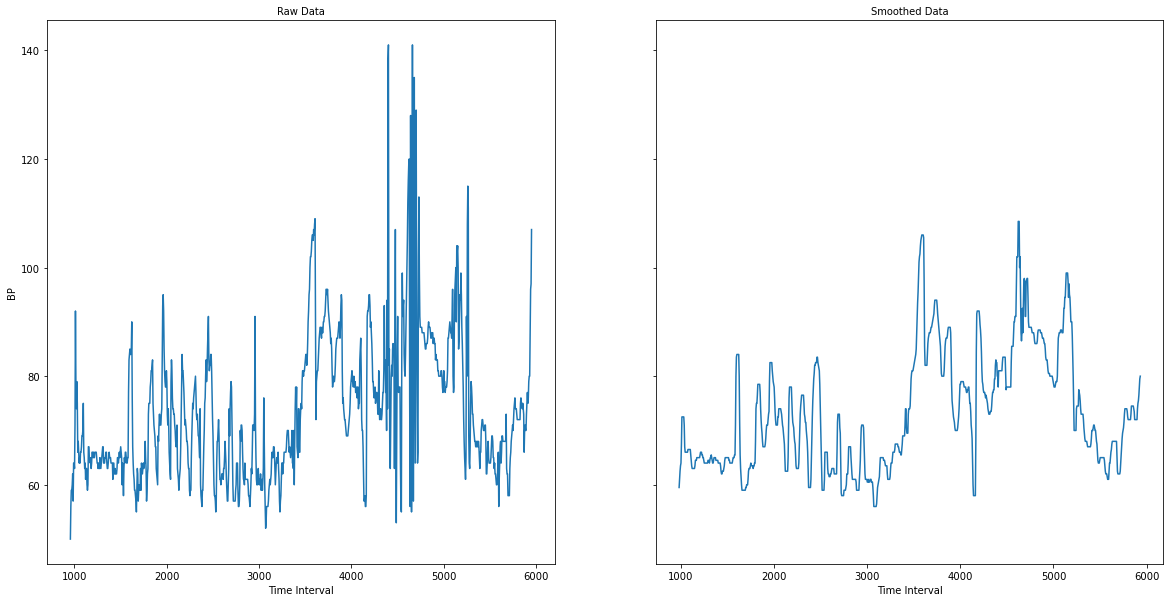

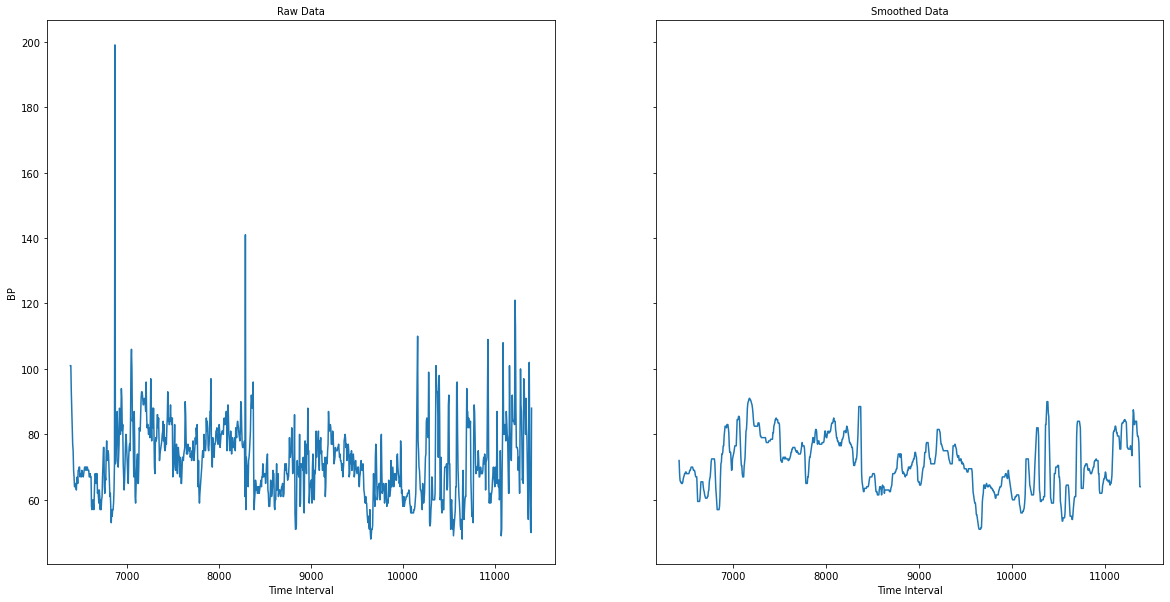

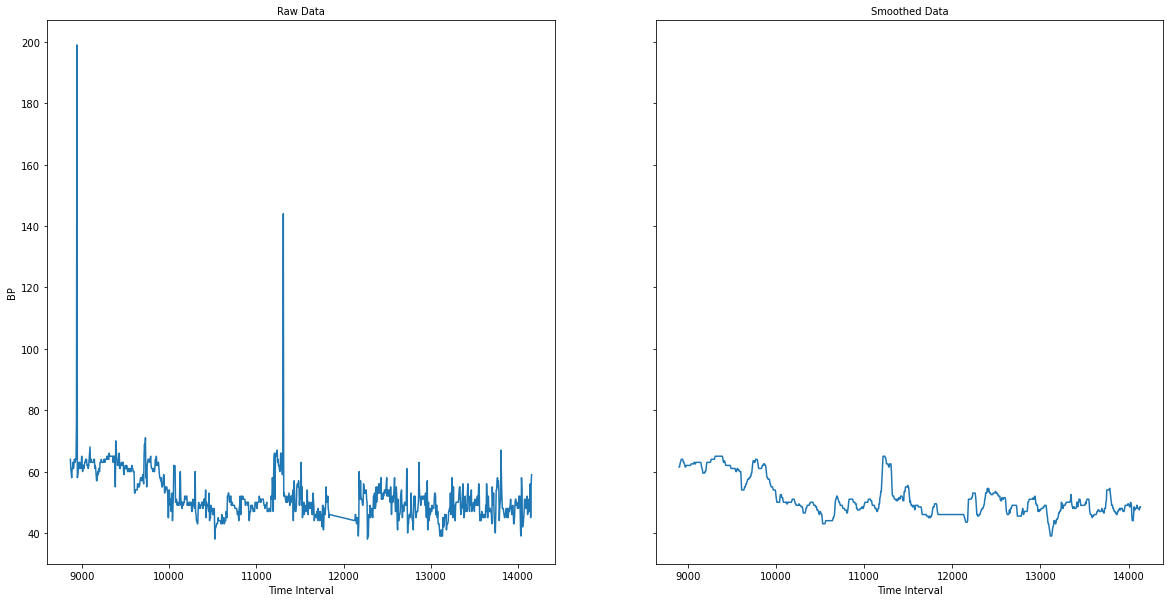

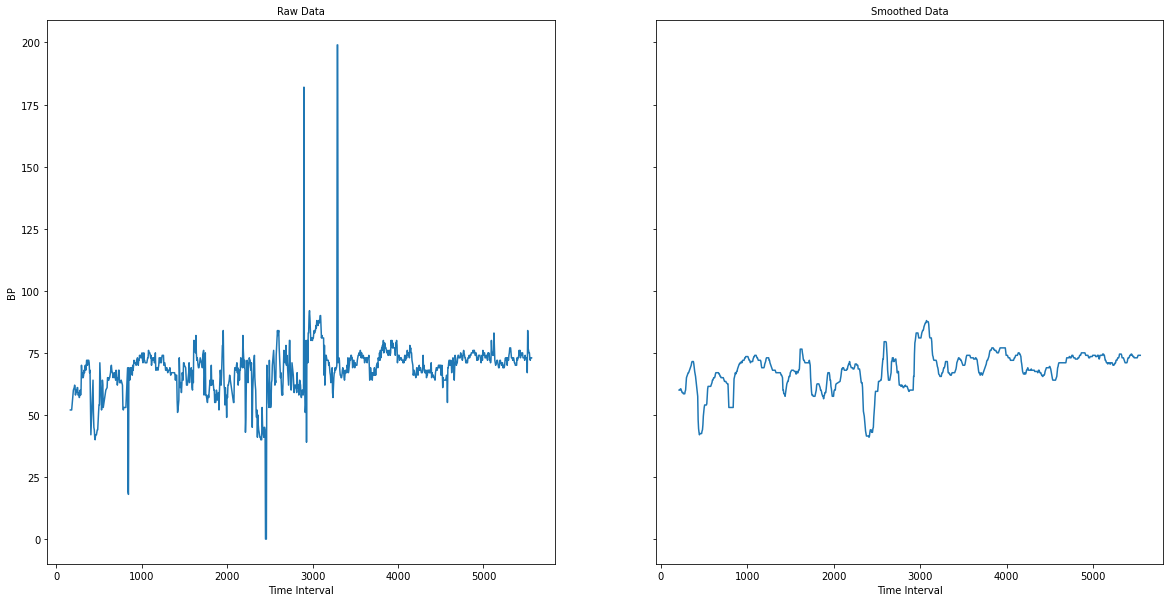

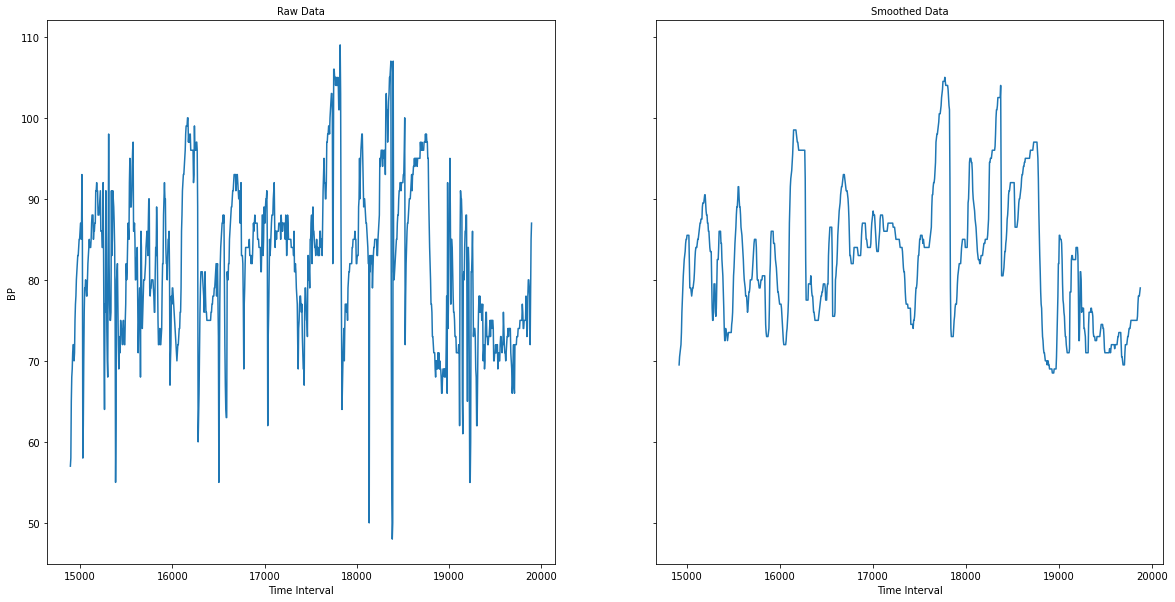

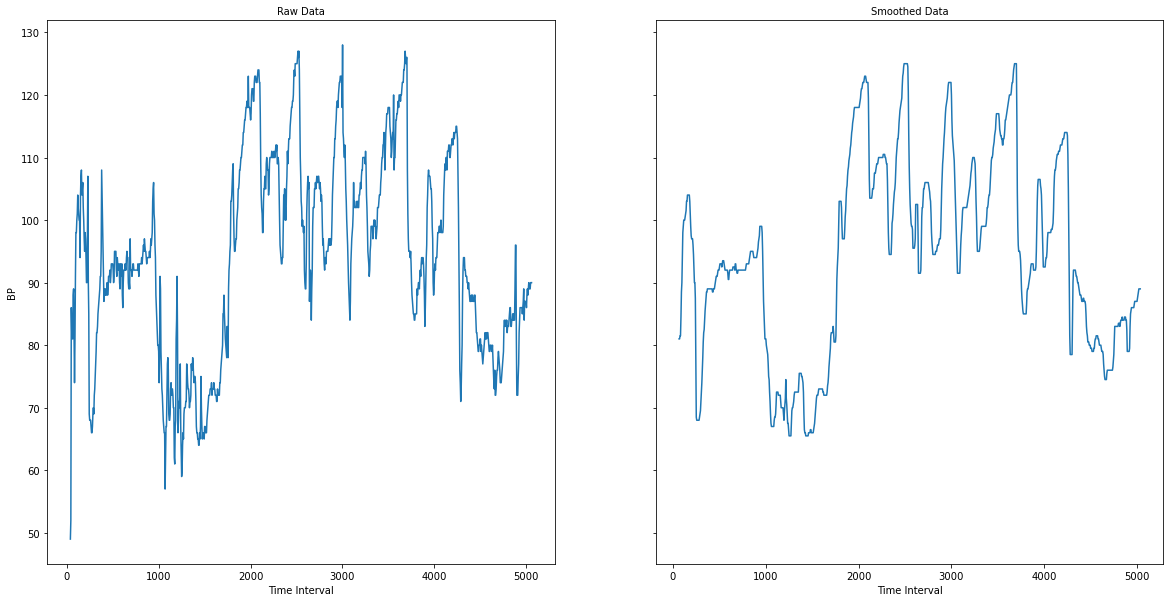

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(10):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

    # assign random patient to pat
    pat = bp_big["stay_id"].value_counts()[bp_big["stay_id"].value_counts() > 0].index[i]
    fig = go.Figure()
    time = bp_big[bp_big["stay_id"] == pat]["cur_bp_time"]
    time = time[:1000]
    raw_bp = bp_big[bp_big["stay_id"] == pat]["cur_bp"]
    raw_bp = raw_bp[:1000]
    data_ = pd.DataFrame(data={'time': time, 'raw_bp': raw_bp})
    
    # Apply rolling median with window size 3
    window_size = 10
    data_['smoothed_bp'] = data_['raw_bp'].rolling(window_size, center=True).median()
    sns.lineplot(ax=axs[0], data=data_, x='time', y='raw_bp')
    sns.lineplot(ax=axs[1], data=data_, x='time', y='smoothed_bp')

    axs[0].set_xlabel("Time Interval")
    axs[0].set_ylabel("BP")
    axs[0].set_title("Raw Data" , fontsize=10)
    axs[1].set_xlabel("Time Interval")
    axs[1].set_ylabel("BP")
    axs[1].set_title("Smoothed Data" , fontsize=10)



    # fig.add_trace(go.Scatter(x=x_bp, y=y_bp, name="MAP"))
    # fig.update_layout(title_text=f"bp over time for patient {i}")
    # fig.write_image(f"bp{i}.png")
    plt.savefig(f"bp{i}.png")


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

for i in range(10):

    # assign random patient to pat
    pat = bp_big["stay_id"].value_counts()[bp_big["stay_id"].value_counts() > 0].index[i]
    fig = make_subplots(rows=3, cols=1)

    time = bp_big[bp_big["stay_id"] == pat]["cur_bp_time"]
    time = time[:1000]
    raw_bp = bp_big[bp_big["stay_id"] == pat]["cur_bp"]
    raw_bp = raw_bp[:1000]
    data_ = pd.DataFrame(data={'time': time, 'raw_bp': raw_bp})
    
    # Apply rolling median with window size 3
    window_size = 10
    filter_size = 10
    data_['smoothed_bp'] = data_['raw_bp'].rolling(window_size, center=True).median()
    data_['dist'] = data_['raw_bp']-data_['smoothed_bp']
    data_['abs_dist'] = np.abs(data_['dist'])
    dist_median = np.nanmedian(data_['abs_dist'])
    data_['dist_median'] = dist_median


    #raw data vs smooth data
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['raw_bp'], mode='lines', marker=dict(color='blue'), name="raw_bp"), row=1, col=1)
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['smoothed_bp'], mode='lines', marker=dict(color='red'), name="smoothed_bp"), row=1, col=1)
    
    #dist with threshhold
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['abs_dist'], mode='lines', name='dist'), row=2, col=1)
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['dist_median']*filter_size, mode='lines', name=f'threshold: {dist_median * filter_size}'), row=2, col=1)
    
    #raw with filtered
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['raw_bp'], mode='lines', name="raw_bp"), row=3, col=1)
    data_ = data_[data_['abs_dist'] <= dist_median * filter_size]
    fig.add_trace(go.Scatter(x=data_['time'], y=data_['raw_bp'], mode='lines', name="filtered_bp"), row=3, col=1)


    fig.update_layout(title_text=f"bp over time for patient {i}\nwindow size: {window_size}\nfilter size: {filter_size}")
    fig.write_image(f"bp{i}.png")
